# Exploração Detalhada do Dataset FER-2013

Análise completa do dataset organizado em pastas.

In [1]:
import sys
from pathlib import Path

# Adicionar o diretório raiz ao path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from collections import Counter

from src.utils.config_loader import config

# Configurar estilo dos gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

%matplotlib inline

## 1. Carregar Configurações

In [2]:
# Configurações do projeto
paths = config.get_paths()
data_dir = paths['data_dir']
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'

# Classes de emoções
emotion_classes = config['dataset']['classes']
num_classes = config['dataset']['num_classes']

print(f"📁 Diretório de dados: {data_dir}")
print(f"📁 Treino: {train_dir}")
print(f"📁 Teste: {test_dir}")
print(f"\nClasses de emoções ({num_classes}):")
for i, emotion in enumerate(emotion_classes):
    print(f"  {i}: {emotion}")

📁 Diretório de dados: /Users/milenemartins/Documents/projetos-pessoais/neuroguide/data
📁 Treino: /Users/milenemartins/Documents/projetos-pessoais/neuroguide/data/train
📁 Teste: /Users/milenemartins/Documents/projetos-pessoais/neuroguide/data/test

Classes de emoções (7):
  0: Raiva
  1: Nojo
  2: Medo
  3: Feliz
  4: Triste
  5: Surpreso
  6: Neutro


## 2. Carregar e Contar Imagens

In [3]:
# Mapear nomes inglês -> português
emotion_map_en_pt = {
    'angry': 'Raiva',
    'disgust': 'Nojo',
    'fear': 'Medo',
    'happy': 'Feliz',
    'neutral': 'Neutro',
    'sad': 'Triste',
    'surprise': 'Surpreso'
}

# Detectar pastas de emoções
train_folders = sorted([d for d in train_dir.iterdir() if d.is_dir()])
test_folders = sorted([d for d in test_dir.iterdir() if d.is_dir()])

emotion_classes_found = [d.name for d in train_folders]

print(f"✓ Encontradas {len(train_folders)} pastas de emoções em train/")
print(f"✓ Encontradas {len(test_folders)} pastas de emoções em test/")
print(f"\nEmoções detectadas: {emotion_classes_found}")

✓ Encontradas 7 pastas de emoções em train/
✓ Encontradas 7 pastas de emoções em test/

Emoções detectadas: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [4]:
# Contar imagens em cada categoria
train_counts = {}
test_counts = {}

for emotion_folder in train_folders:
    emotion = emotion_folder.name
    image_files = list(emotion_folder.glob('*.jpg')) + list(emotion_folder.glob('*.png'))
    train_counts[emotion] = len(image_files)

for emotion_folder in test_folders:
    emotion = emotion_folder.name
    image_files = list(emotion_folder.glob('*.jpg')) + list(emotion_folder.glob('*.png'))
    test_counts[emotion] = len(image_files)

print("📊 Distribuição do Dataset:\n")
print(f"{'Emoção':<15} {'Português':<12} {'Treino':<10} {'Teste':<10} {'Total':<10}")
print("=" * 60)

total_train = 0
total_test = 0

for emotion in emotion_classes_found:
    train_cnt = train_counts.get(emotion, 0)
    test_cnt = test_counts.get(emotion, 0)
    total = train_cnt + test_cnt
    total_train += train_cnt
    total_test += test_cnt
    pt_name = emotion_map_en_pt.get(emotion, emotion)
    print(f"{emotion:<15} {pt_name:<12} {train_cnt:<10} {test_cnt:<10} {total:<10}")

print("=" * 60)
print(f"{'TOTAL':<15} {'':<12} {total_train:<10} {total_test:<10} {total_train + total_test:<10}")

📊 Distribuição do Dataset:

Emoção          Português    Treino     Teste      Total     
angry           Raiva        3995       958        4953      
disgust         Nojo         436        111        547       
fear            Medo         4097       1024       5121      
happy           Feliz        7215       1774       8989      
neutral         Neutro       4965       1233       6198      
sad             Triste       4830       1247       6077      
surprise        Surpreso     3171       831        4002      
TOTAL                        28709      7178       35887     


## 3. Visualizar Distribuição

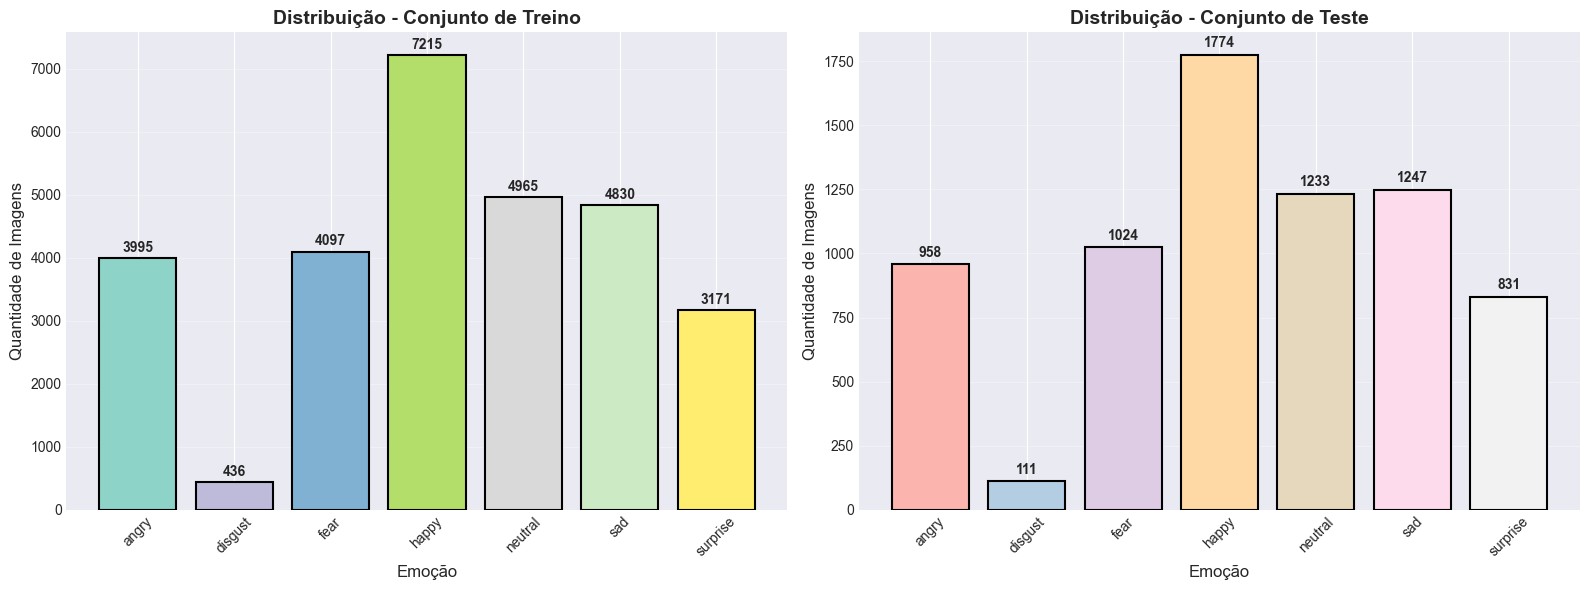

In [5]:
# Plotar distribuição lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

emotions_sorted = sorted(train_counts.keys())
train_values = [train_counts[e] for e in emotions_sorted]
test_values = [test_counts[e] for e in emotions_sorted]

# Treino
colors_train = plt.cm.Set3(np.linspace(0, 1, len(emotions_sorted)))
ax1.bar(emotions_sorted, train_values, color=colors_train, edgecolor='black', linewidth=1.5)
ax1.set_title('Distribuição - Conjunto de Treino', fontsize=14, fontweight='bold')
ax1.set_xlabel('Emoção', fontsize=12)
ax1.set_ylabel('Quantidade de Imagens', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for i, v in enumerate(train_values):
    ax1.text(i, v + 100, str(v), ha='center', fontweight='bold')

# Teste
colors_test = plt.cm.Pastel1(np.linspace(0, 1, len(emotions_sorted)))
ax2.bar(emotions_sorted, test_values, color=colors_test, edgecolor='black', linewidth=1.5)
ax2.set_title('Distribuição - Conjunto de Teste', fontsize=14, fontweight='bold')
ax2.set_xlabel('Emoção', fontsize=12)
ax2.set_ylabel('Quantidade de Imagens', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for i, v in enumerate(test_values):
    ax2.text(i, v + 30, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Visualizar Exemplos de Cada Emoção

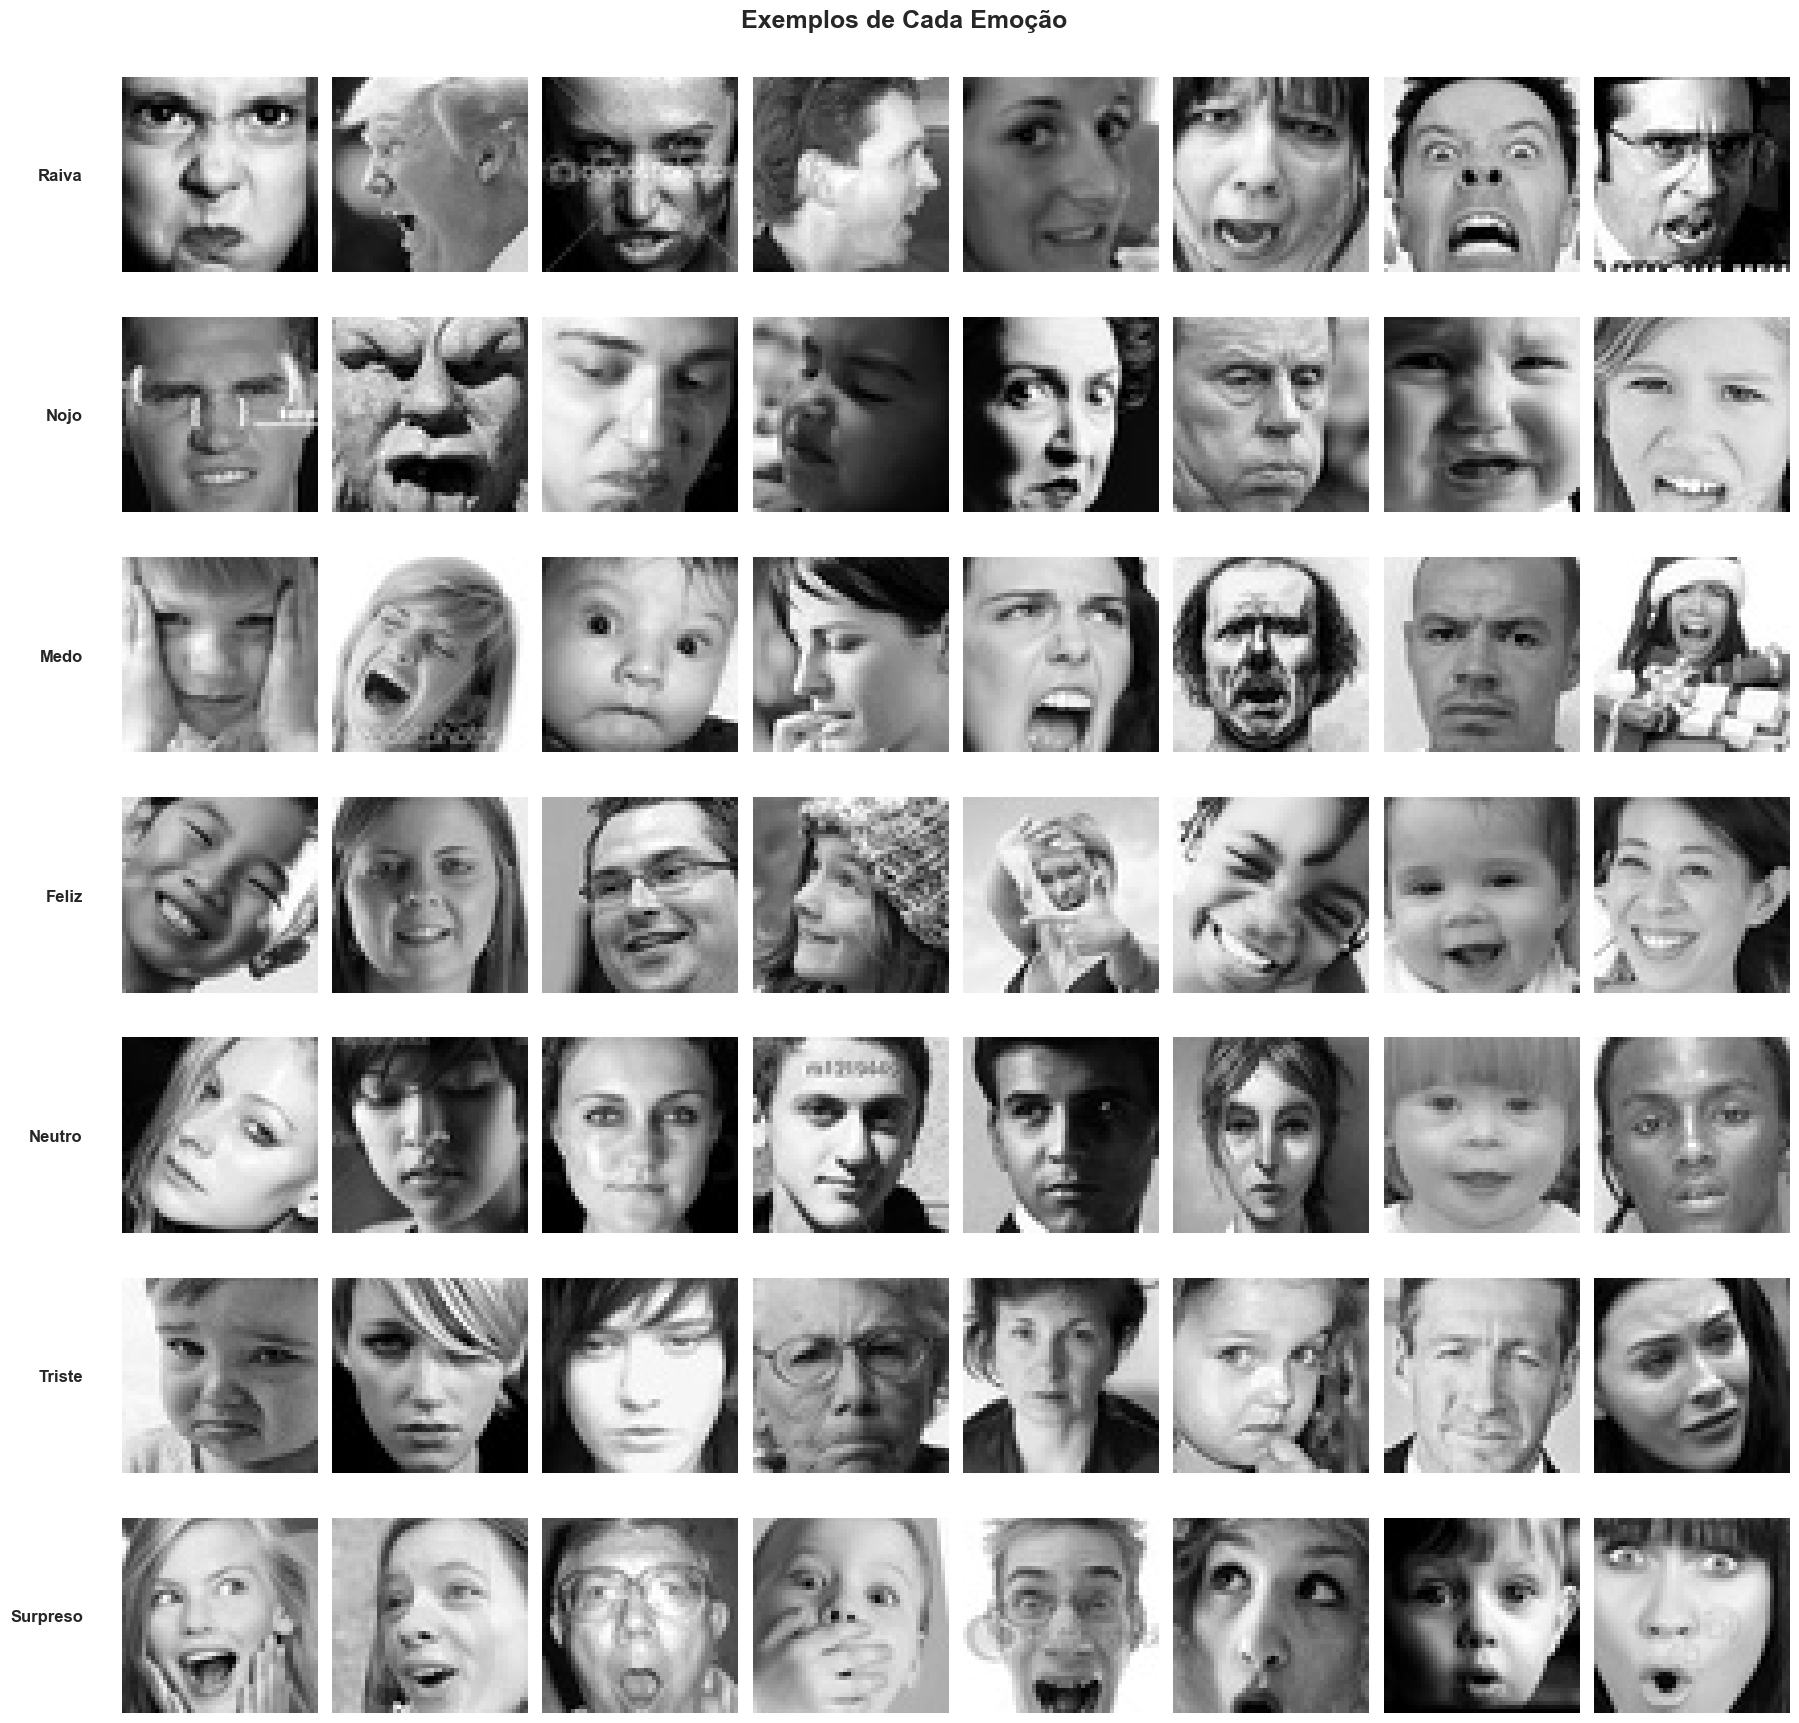

In [6]:
# Plotar grid de exemplos
n_emotions = len(emotion_classes_found)
n_examples = 8

fig, axes = plt.subplots(n_emotions, n_examples, figsize=(18, 2.5 * n_emotions))
fig.suptitle('Exemplos de Cada Emoção', fontsize=18, fontweight='bold', y=0.995)

for row, emotion in enumerate(emotion_classes_found):
    emotion_path = train_dir / emotion
    image_files = list(emotion_path.glob('*.jpg')) + list(emotion_path.glob('*.png'))
    
    # Selecionar exemplos aleatórios
    selected = random.sample(image_files, min(n_examples, len(image_files)))
    
    for col, img_path in enumerate(selected):
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        
        ax = axes[row, col]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        
        # Título na primeira coluna
        if col == 0:
            pt_name = emotion_map_en_pt.get(emotion, emotion)
            ax.text(-10, 24, f"{pt_name}", 
                   fontsize=12, fontweight='bold', 
                   ha='right', va='center')

plt.tight_layout()
plt.show()

## 5. Análise de Características das Imagens

In [7]:
# Carregar amostra de imagens para análise
sample_size = 1000
sample_images = []
sample_labels = []

for emotion in emotion_classes_found:
    emotion_path = train_dir / emotion
    image_files = list(emotion_path.glob('*.jpg')) + list(emotion_path.glob('*.png'))
    
    # Pegar proporcionalmente de cada classe
    n_samples = min(sample_size // len(emotion_classes_found), len(image_files))
    selected = random.sample(image_files, n_samples)
    
    for img_path in selected:
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            sample_images.append(img)
            sample_labels.append(emotion)

sample_images = np.array(sample_images)

print(f"Analisando {len(sample_images)} imagens...")
print(f"\n📐 Dimensões:")
print(f"  Formato: {sample_images[0].shape}")
print(f"  Tamanho: {sample_images[0].shape[0]}x{sample_images[0].shape[1]} pixels")
print(f"\n📊 Estatísticas dos Pixels:")
print(f"  Média: {sample_images.mean():.2f}")
print(f"  Mediana: {np.median(sample_images):.2f}")
print(f"  Desvio Padrão: {sample_images.std():.2f}")
print(f"  Mínimo: {sample_images.min()}")
print(f"  Máximo: {sample_images.max()}")

Analisando 994 imagens...

📐 Dimensões:
  Formato: (48, 48)
  Tamanho: 48x48 pixels

📊 Estatísticas dos Pixels:
  Média: 132.74
  Mediana: 139.00
  Desvio Padrão: 64.38
  Mínimo: 0
  Máximo: 255


/var/folders/cv/dflf349j79s03873mkjhgkfm0000gn/T/ipykernel_49343/499978457.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(pixel_data_by_emotion, labels=emotion_classes_found)


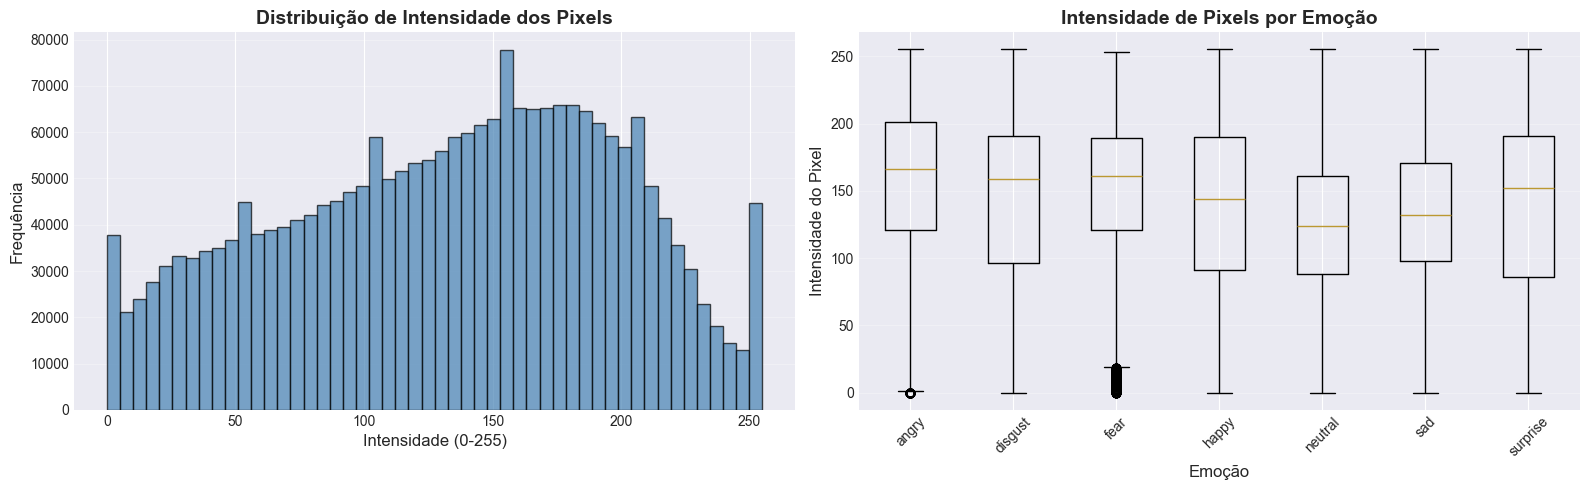

In [8]:
# Distribuição de intensidade dos pixels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Histograma
ax1.hist(sample_images.flatten(), bins=50, edgecolor='black', color='steelblue', alpha=0.7)
ax1.set_title('Distribuição de Intensidade dos Pixels', fontsize=14, fontweight='bold')
ax1.set_xlabel('Intensidade (0-255)', fontsize=12)
ax1.set_ylabel('Frequência', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Box plot por emoção
pixel_data_by_emotion = []
for emotion in emotion_classes_found:
    emotion_indices = [i for i, label in enumerate(sample_labels) if label == emotion]
    emotion_pixels = sample_images[emotion_indices].flatten()
    pixel_data_by_emotion.append(emotion_pixels[:10000])  # Limitar para performance

ax2.boxplot(pixel_data_by_emotion, labels=emotion_classes_found)
ax2.set_title('Intensidade de Pixels por Emoção', fontsize=14, fontweight='bold')
ax2.set_xlabel('Emoção', fontsize=12)
ax2.set_ylabel('Intensidade do Pixel', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Análise de Balanceamento

In [9]:
# Calcular balanceamento
total_train = sum(train_counts.values())
expected_per_class = total_train / len(emotion_classes_found)

print("⚖️ Análise de Balanceamento:\n")
print(f"Total: {total_train} imagens")
print(f"Esperado por classe (balanceado): {expected_per_class:.0f}\n")
print(f"{'Emoção':<12} {'Quantidade':<12} {'%':<8} {'Diferença':<12}")
print("=" * 50)

for emotion in sorted(train_counts.keys(), key=lambda x: train_counts[x], reverse=True):
    count = train_counts[emotion]
    percentage = (count / total_train) * 100
    diff = count - expected_per_class
    print(f"{emotion:<12} {count:<12} {percentage:>6.2f}% {diff:>+10.0f}")

min_class = min(train_counts, key=train_counts.get)
max_class = max(train_counts, key=train_counts.get)

print("\n" + "=" * 50)
print(f"⚠️  Classe MINORITÁRIA: {min_class} ({train_counts[min_class]} imagens)")
print(f"✓  Classe MAJORITÁRIA: {max_class} ({train_counts[max_class]} imagens)")
print(f"📊 Razão: {train_counts[max_class] / train_counts[min_class]:.2f}x")

⚖️ Análise de Balanceamento:

Total: 28709 imagens
Esperado por classe (balanceado): 4101

Emoção       Quantidade   %        Diferença   
happy        7215          25.13%      +3114
neutral      4965          17.29%       +864
sad          4830          16.82%       +729
fear         4097          14.27%         -4
angry        3995          13.92%       -106
surprise     3171          11.05%       -930
disgust      436            1.52%      -3665

⚠️  Classe MINORITÁRIA: disgust (436 imagens)
✓  Classe MAJORITÁRIA: happy (7215 imagens)
📊 Razão: 16.55x
